# Imports

# Pipeline


1.   Tratamento dos Dados
2.   Configuração da Rede
3.   Treinamento
4.   Teste
5.   Conclusões


# 📈 Objetivos do Projeto
1. Aplicação da Arquitetura da Yolo V3, V5, V7 ❌
2. Fine-Tuning delas para nosso Dataset ❌
3. Benchmark das Yolos explicando o porquê dos resultados obtidos ❌
4. Uso de uma ou mais CNNs clássicas no Dataset e fazer um benchmark das mesmas com a Yolo, explicando seus resultados ❌
---
# 🗿 Objetivos extras
*   Normalizar o Dataset ✅
*   Fazer Data Augmentation no Dataset ❌
*   Buscar uma versão quantizada do Modelo e Testar ❌
*   Testar a Fast-YOLO ❌



# 1. Tratamento dos Dados

## 1.1 Download dos Dados
O tempo médio para essa pipeline terminar é de 10min

In [3]:
import git
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio.v2 as imageio
import numpy as np
# import utils
# import torch
from git import Repo
from glob import glob
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split

In [10]:
cur_dir = os.getcwd()

In [4]:


def clone_repository(repo_url, dest_folder=''):
    Repo.clone_from(repo_url, dest_folder)


In [3]:
clone_repository('https://github.com/tnpb-1st/dl-project-datasets.git', 'original_data')

## 1.2 Tratamento dos Dados

In [5]:
PRES_LINE_BREAK = "-"*50

### Criação do Dataframe e informações básicas do mesmo

In [6]:
def create_dataframe_from_images_dir(base_dir:str, csv_orig_dir:str):
    """
    Cria um DataFrame do pandas contendo informações sobre imagens em um diretório.

    Parâmetros:
    - base_dir: str, o diretório base onde as imagens e o arquivo CSV estão localizados.
    - csv_filename: str, o nome do arquivo CSV com os rótulos das imagens.

    Retorna:
    - Um DataFrame do pandas com colunas para o ID do paciente, caminho da imagem, existência do arquivo de imagem,
      olho (esquerdo/direito) e rótulos categóricos para o nível da doença.
    """
    # Constrói o caminho para o arquivo CSV
    shutil.copy(csv_orig_dir, base_dir)
    csv_filename = csv_orig_dir.split('/')[-1]
    csv_path = os.path.join(base_dir, csv_filename)

    # Lê o arquivo CSV em um DataFrame
    df = pd.read_csv(csv_path)

    # Extrai o ID do paciente da coluna de imagem
    df['PatientId'] = df['image'].map(lambda x: x.split('_')[0])

    # Constrói o caminho para cada imagem
    df['path'] = df['image'].map(lambda x: os.path.join(base_dir, '{}.jpeg'.format(x)))

    # Verifica se o arquivo de imagem existe
    df['exists'] = df['path'].map(os.path.exists)

    # Determina o olho (esquerdo/direito) com base no nome da imagem
    df['eye'] = df['image'].map(lambda x: 1 if x.split('_')[-1] == 'left' else 0)

    # Supondo que exista uma coluna 'level' para a gravidade da doença; cria rótulos categóricos
    df['level_cat'] = pd.Categorical(df['level'])

    # Descarta linhas para as quais o arquivo de imagem não existe
    df = df[df['exists']]

    return df


In [11]:
df = create_dataframe_from_images_dir(f'{cur_dir}/train/train_1024_1024', f'{cur_dir}/trainLabels.csv')

In [12]:
# shape
print(f"Dataset Shape: {df.shape}")
# dataframe sample
print(PRES_LINE_BREAK)
df.sample(3)

Dataset Shape: (35126, 7)
--------------------------------------------------


,image,level,PatientId,path,exists,eye,level_cat
2828,3518_left,0,3518,/home/tomas-barros/Codes/dl-project-datasets/t...,True,1,0
1746,2185_left,0,2185,/home/tomas-barros/Codes/dl-project-datasets/t...,True,1,0
12407,15563_right,0,15563,/home/tomas-barros/Codes/dl-project-datasets/t...,True,0,0


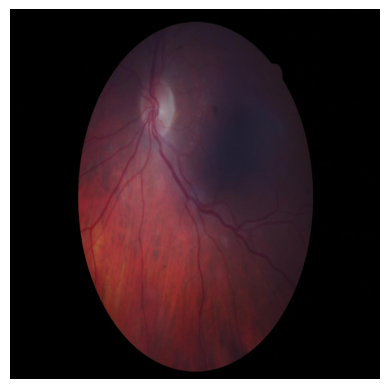

In [13]:
# img test
_img = mpimg.imread(f'{cur_dir}/train/train_1024_1024/947_left.jpeg')
plt.imshow(_img)
plt.axis('off')
plt.show()

### Normalização dos Dados
Vamos normalizar os dados de forma que todas as categorias tenham o mesmo número de exemplos. Infelizmente teremos o possível ônus de perder dados ao fazermos isso, mas planejamos testar futuramente com data Augmentation

#### Examinando a distribuição Atual

array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

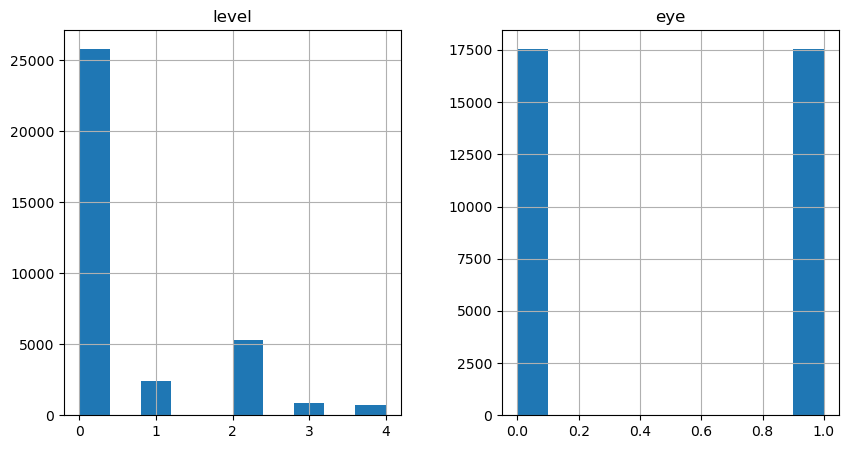

In [14]:
df[['level', 'eye']].hist(figsize = (10, 5))

In [15]:
def normalize_dataframe(df):
    """
    Normaliza o DataFrame dado, realizando amostragem estratificada para criar conjuntos de treino e validação,
    e depois realiza uma amostragem para igualar o número de exemplos em cada categoria.

    Parâmetros:
    - df: DataFrame, o DataFrame a ser normalizado.

    Retorna:
    - Uma tupla contendo o DataFrame de treino normalizado e o DataFrame de validação.
    """
    # Remove duplicatas considerando apenas 'PatientId' e 'level'
    rr_df = df[['PatientId', 'level']].drop_duplicates()

    # Divide os dados em conjuntos de treino e validação de forma estratificada
    train_ids, valid_ids = train_test_split(rr_df['PatientId'],
                                            test_size=0.25,
                                            random_state=2018,
                                            stratify=rr_df['level'])

    # Cria os DataFrames de treino e validação usando os IDs selecionados
    raw_train_df = df[df['PatientId'].isin(train_ids)]
    valid_df = df[df['PatientId'].isin(valid_ids)]
    print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

    # Realiza uma amostragem para igualar o número de exemplos para cada combinação de 'level' e 'eye'
    train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace=True)
                                                           ).reset_index(drop=True)
    print('Novo Tamanho dos Dados: ', train_df.shape[0], 'Tamanho Antigo:', raw_train_df.shape[0])

    # Retorna os DataFrames de treino e validação normalizados
    return train_df, valid_df

In [16]:
df_norm_train, df_norm_test = normalize_dataframe(df)

train 27176 validation 9632
Novo Tamanho dos Dados:  750 Tamanho Antigo: 27176


array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

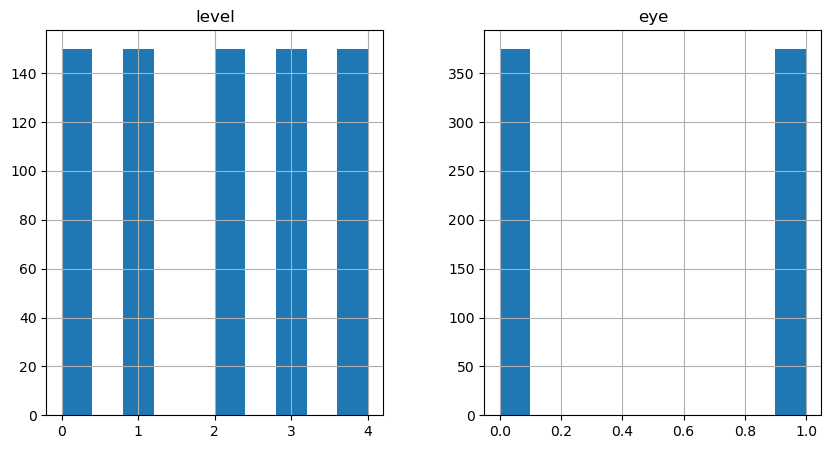

In [17]:
df_norm_train[['level', 'eye']].hist(figsize = (10, 5))

In [18]:
df_norm_train.head()

,image,level,PatientId,path,exists,eye,level_cat
0,10674_right,0,10674,/home/tomas-barros/Codes/dl-project-datasets/t...,True,0,0
1,20205_right,0,20205,/home/tomas-barros/Codes/dl-project-datasets/t...,True,0,0
2,27480_right,0,27480,/home/tomas-barros/Codes/dl-project-datasets/t...,True,0,0
3,35339_right,0,35339,/home/tomas-barros/Codes/dl-project-datasets/t...,True,0,0
4,17259_right,0,17259,/home/tomas-barros/Codes/dl-project-datasets/t...,True,0,0


#### Data Augmentation


In [19]:
def create_directory_structure(parent_dir):
    """
    Verifica se o diretório pai e cada um dos subdiretórios já existem antes de tentar criá-los.
    Cria uma estrutura de diretórios para treinamento, teste e validação com categorias de 0 a 4.

    :param parent_dir: nome do diretório pai para criar a estrutura de diretórios
    """
    # Verifica se o diretório pai existe, se não, cria
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)

    # Define os subdiretórios para treinamento, teste e validação
    subdirs = ['train', 'test', 'val']

    # Cria os diretórios e subdiretórios necessários
    for subdir in subdirs:
        for category in range(5):  # Categorias de 0 a 4
            # Constrói o caminho para cada subdiretório de categoria
            dir_path = os.path.join(parent_dir, subdir, str(category))
            # Verifica se o diretório já existe antes de tentar criá-lo
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

In [20]:
def augment_images_from_df(df, augmented_output_dir, threshold, add_txt_label=False, exclude_original_images=True):
    if not os.path.exists(augmented_output_dir):
        os.makedirs(augmented_output_dir)

    seq = iaa.Sequential([
        iaa.SomeOf(1, [
            iaa.Affine(rotate=(-15, 15)),
            iaa.Affine(scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}),
            iaa.TranslateX(percent=(-0.1, 0.1)),
            iaa.TranslateY(percent=(-0.1, 0.1)),
        ]),
        iaa.ElasticTransformation(alpha=(0, 5.0), sigma=0.25),
    ], random_order=True)

    for level_cat, group in df.groupby('level_cat'):
        label_dir = os.path.join(augmented_output_dir, str(level_cat))
        os.makedirs(label_dir, exist_ok=True)

        # Se a categoria tiver mais amostras que o threshold, seleciona uma amostra representativa
        if len(group) > threshold:
            group = group.sample(n=threshold, random_state=42)

        current_samples = len(group)
        additional_samples_needed = max(0, threshold - current_samples)

        augmentation_rounds = np.ceil(additional_samples_needed / current_samples).astype(int) if additional_samples_needed > 0 else 1

        for _, row in group.iterrows():
            image_path = row['path']
            image = imageio.imread(image_path)

            for i in range(augmentation_rounds):
                # Aplica a transformação mesmo se não precisarmos de imagens adicionais para garantir variabilidade
                image_aug = seq(image=image) if augmentation_rounds > 0 else image
                augmented_image_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_aug_{i}.png"
                augmented_image_path = os.path.join(label_dir, augmented_image_filename)
                imageio.imwrite(augmented_image_path, image_aug)

                if add_txt_label:
                    txt_label_path = os.path.join(label_dir, f"{os.path.splitext(augmented_image_filename)[0]}.txt")
                    with open(txt_label_path, 'w') as txt_file:
                        txt_file.write(str(level_cat))


In [21]:
def merge_images_dir(parent_dir, df_valid, df_test):
    """
    Organiza imagens em diretórios de validação e teste com base em DataFrames fornecidos.

    :param parent_dir: diretório pai onde todas as imagens serão organizadas
    :param df_valid: DataFrame com as imagens de validação
    :param df_test: DataFrame com as imagens de teste
    """
    # Cria diretórios de validação e teste, se não existirem
    val_dir = os.path.join(parent_dir, 'val')
    test_dir = os.path.join(parent_dir, 'test')
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Função para copiar imagens para o diretório correspondente
    def copy_images(df, target_dir):
        for _, row in df.iterrows():
            level_cat = row['level_cat']
            image_path = row['path']
            dest_dir = os.path.join(target_dir, str(level_cat))
            os.makedirs(dest_dir, exist_ok=True)  # Cria o diretório de destino, se não existir

            # Copia a imagem para o diretório de destino
            shutil.copy(image_path, os.path.join(dest_dir, os.path.basename(image_path)))

    # Copia as imagens de validação e teste para os diretórios correspondentes
    copy_images(df_valid, val_dir)
    copy_images(df_test, test_dir)

In [22]:
create_directory_structure(f'{cur_dir}/yolo_data')

In [ ]:
augment_images_from_df(df, f'{cur_dir}/yolo_data/train', 5000, add_txt_label=False, exclude_original_images=True)

In [ ]:
def split_and_copy_images(df, parent_dir):
    # Encontra o número mínimo de amostras entre as categorias
    min_samples = df['level_cat'].value_counts().min()

    # Cria os diretórios de validação e teste, se não existirem
    val_dir = os.path.join(parent_dir, 'val')
    test_dir = os.path.join(parent_dir, 'test')
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for category in df['level_cat'].unique():
        category_df = df[df['level_cat'] == category]

        # Seleciona aleatoriamente 'min_samples' de cada categoria
        if len(category_df) > min_samples:
            category_df = category_df.sample(n=min_samples, random_state=42)

        # Divide os dados em conjuntos de teste e validação
        train_df, val_df = train_test_split(category_df, test_size=0.5, random_state=42)

        # Função auxiliar para copiar imagens para o diretório correto
        def copy_images(images_df, target_dir):
            target_category_dir = os.path.join(target_dir, str(category))
            os.makedirs(target_category_dir, exist_ok=True)
            for _, row in images_df.iterrows():
                src_path = row['path']
                dst_path = os.path.join(target_category_dir, os.path.basename(src_path))
                shutil.copy(src_path, dst_path)

        # Copia as imagens para os diretórios apropriados
        copy_images(train_df, test_dir)
        copy_images(val_df, val_dir)

In [ ]:
split_and_copy_images(df, 'yolo_data')

In [ ]:
def count_images(directory):
    for root, dirs, files in os.walk(directory):
        # Use glob to filter files with image extensions
        image_files = glob.glob(os.path.join(root, '*.[jJ][pP][gG]')) + \
                      glob.glob(os.path.join(root, '*.[jJ][pP][eE][gG]')) + \
                      glob.glob(os.path.join(root, '*.[pP][nN][gG]')) + \
                      glob.glob(os.path.join(root, '*.[gG][iI][fF]')) + \
                      glob.glob(os.path.join(root, '*.[bB][mM][pP]')) + \
                      glob.glob(os.path.join(root, '*.[tT][iI][fF][fF]')) + \
                      glob.glob(os.path.join(root, '*.[tT][iI][fF]')) + \
                      glob.glob(os.path.join(root, '*.[jJ][pP][2]')) + \
                      glob.glob(os.path.join(root, '*.[jJ][2]'))

        num_images = len(image_files)
        if num_images > 0:
            print(f"{root} - {num_images} images")

In [ ]:
count_images(f'{cur_dir}/yolo_data')

In [ ]:
os.makedirs(f'{cur_dir}/test_data')

In [ ]:
def copy_and_reorganize_yolo_data(source_dir, new_dir):
    # Ensure the new directories are created
    os.makedirs(os.path.join(new_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(new_dir, 'val'), exist_ok=True)
    os.makedirs(os.path.join(new_dir, 'test'), exist_ok=True)

    # Copy /val to new_dir/train
    for category in range(5):
        source_path = os.path.join(source_dir, 'val', str(category))
        dest_path = os.path.join(new_dir, 'train', str(category))
        os.makedirs(dest_path, exist_ok=True)
        for file in glob(os.path.join(source_path, '*')):
            shutil.copy(file, dest_path)

    # Split /test into new_dir/val and new_dir/test evenly
    for category in range(5):
        source_path = os.path.join(source_dir, 'test', str(category))
        files = glob(os.path.join(source_path, '*'))
        # Shuffle files to randomly select for val and test
        np.random.shuffle(files)
        midpoint = len(files) // 2  # Find the midpoint for splitting

        for dest_subdir, file_subset in zip(('val', 'test'), (files[:midpoint], files[midpoint:])):
            dest_path = os.path.join(new_dir, dest_subdir, str(category))
            os.makedirs(dest_path, exist_ok=True)
            for file in file_subset:
                shutil.copy(file, dest_path)

# Example usage
# copy_and_reorganize_yolo_data(f'{cur_dir}/yolo_data/', '/path/to/new_dir')


In [ ]:
# copy_and_reorganize_yolo_data(f'{cur_dir}/yolo_data', f'{cur_dir}/test_data')

In [ ]:
# count_images(f'{cur_dir}/test_data')

/content/test_data/train/0 - 149 images
/content/test_data/train/4 - 131 images
/content/test_data/train/2 - 149 images
/content/test_data/train/3 - 140 images
/content/test_data/train/1 - 145 images
/content/test_data/val/0 - 3379 images
/content/test_data/val/4 - 101 images
/content/test_data/val/2 - 787 images
/content/test_data/val/3 - 131 images
/content/test_data/val/1 - 416 images
/content/test_data/test/0 - 3380 images
/content/test_data/test/4 - 102 images
/content/test_data/test/2 - 788 images
/content/test_data/test/3 - 131 images
/content/test_data/test/1 - 417 images


# 2. Modelos de Redes Neurais

## 2.1 - Família Yolo

### 2.1.2 - Yolo V5

In [ ]:
# importando o modelo
clone_repository('https://github.com/ultralytics/yolov5', f'{cur_dir}/yolov5')
%cd yolov5
%pip install -qr requirements.txt  # install
display = utils.notebook_init()  # checks

In [ ]:
# baixando os pesos
%cd ../yolov5

p5 = ['n', 's', 'm', 'l', 'x']  # P5 models
cls = [f'{x}-cls' for x in p5]  # classification models

for x in cls:
    attempt_download(f'weights/yolov5{x}.pt')

#### Treinamento

In [ ]:
for i in range(1, 6):
  weights = ff'{cur_dir}/yolov5/runs/train-cls/exp{i}/weights/best.pt'
  if i == 1:
    weights = f'{cur_dir}/yolov5/weights/yolov5s-cls.pt'
  with open('set_variable.sh', 'w') as file:
    file.write(f'WEIGHTS_PATH="{weights}"\n')
  !sh ./set_variable.sh
  !python classify/train.py --model yolov5s-cls.pt --data {cur_dir}/yolo_data --epochs 20 --img 1024 --pretrained $WEIGHTS_PATH --batch-size 256 --device 0 --dropout 0.2
  !python classify/val.py --weights $WEIGHTS_PATH --data {cur_dir}/yolo_data
# !python classify/train.py --model yolov5s-cls.pt --data $DATASET_NAME --epochs 20 --img 128 --pretrained weights/yolov5s-cls.pt
# !python classify/train.py --model yolov5s-cls.pt --data {cur_dir}/yolo_data --epochs 20 --img 256 --pretrained {cur_dir}/yolov5/runs/train-cls/exp2/weights/best.pt --batch-size 354 --device 0

2024-03-10 21:53:07.497419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 21:53:07.497482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 21:53:07.499566: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
classify/train: model=yolov5s-cls.pt, data=/content/test_data, epochs=10, batch_size=64, imgsz=512, nosave=False, cache=None, device=0, workers=8, project=runs/train-cls, name=exp, exist_ok=False, pretrained=/content/yolov5/runs/train-cls/exp2/weights/best.pt, optimizer=Adam, lr0=0.001, decay=5e-05, label_smoothing=0.1, cutoff=None, dropout=None, verbose=False, s

In [ ]:
!cp {cur_dir}/yolov5/runs/train-cls/exp2/weights/best.pt {cur_dir}/gdrive/MyDrive/yolov5_weights/best_512_exp2t

In [ ]:
!python classify/val.py --weights runs/train-cls/exp/weights/best.pt --data {cur_dir}/yolo_data

classify/val: data=/content/yolo_data, weights=['runs/train-cls/exp/weights/best.pt'], batch_size=128, imgsz=224, device=, workers=8, verbose=True, project=runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

Fusing layers... 
Model summary: 117 layers, 4173093 parameters, 0 gradients, 10.4 GFLOPs
testing: 100% 76/76 [01:45<00:00,  1.38s/it]
                   Class      Images    top1_acc    top5_acc
                     all        9632       0.587           1
                       0        6759       0.809           1
                       1         833       0.182           1
                       2        1575      0.0178           1
                       3         262           0           1
                       4         203      0.0493           1
Speed: 0.1ms pre-process, 0.2ms inference, 0.0ms post-process per image at shape (1, 3, 224, 224)
Results saved to run

### 2.1.3 - Yolo V7

## 2.2 - CNNs Clássicas



# 3. Treinamento (Fine-Tuning)

# 4. Teste

# 5. Conclusões